In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab 
import scipy.stats as stats
import math

In [1]:
# 导入数据
def load_data():
    print("/----------------------------------------------------/")
    print("Start loading data:")
    data = pd.read_excel('../data/only-score.xlsx')
    data.drop(['Unnamed: 0'], axis=1, inplace=True)
    print("Finish loading data!\nShape of data:", data.shape)
    return data

In [3]:
# 根据缺失数据位置进行切片，得到无缺失的评分矩阵
def drop_all_na(df):
    print("/----------------------------------------------------/")
    print("Start droping all 'nan' values:")
    if not isinstance(df, pd.DataFrame):
        print("ERROR: Not DF.")
        return df
    ret_df = df.copy()
    ret_df.dropna(axis=1, how="all", inplace=True)
    ret_df.dropna(axis=0, how="any", inplace=True)
    print("Finish droping!\nShape of data:", ret_df.shape)
    return ret_df

In [4]:
# 丢弃完全缺失的数据，得到部分缺失的评分矩阵
def drop_partail_na(df):
    print("/----------------------------------------------------/")
    print("Start droping partial 'nan' values:")
    if not isinstance(df, pd.DataFrame):
        print("ERROR: Not DF.")
        return df
    ret_df = df.copy()
    ret_df.dropna(axis=1, how="all", inplace=True)
    ret_df.dropna(axis=0, how="all", inplace=True)
    print("Finish droping!\nShape of data:", ret_df.shape)
    return ret_df

In [5]:
# 打印评分Series的柱状图
def print_bar(data):
    plt.figure()
    plt.bar(data.index, data)
    plt.show()
    return
def print_dup_bar(data_list):
    total_width, n = 1, len(data_list) + 1
    width = total_width / n
    for i in range(len(data_list)):
        plt.bar(data_list[i].index + width * i, data_list[i], width=width)
    plt.show()

In [6]:
# 检查是否对自己评分出现误差
def solve_selfish(data):
    print("/----------------------------------------------------/")
    print("Start checking selfishness:")
    self_score = pd.Series(data=data.columns.isin(data.index), index=data.columns)
    for column in data.columns:
        if not self_score[column]:
            continue
        if data.at[column, column] == np.nan:
            continue
        mean = data.loc[:,column].drop(column).mean(skipna=True)
        std = data.loc[:,column].drop(column).std(skipna=True)
        conf_intveral = stats.norm.interval(0.9, loc=mean, scale=std)
        if data.at[column, column] > conf_intveral[1]:
            data.at[column, column] = mean
            print(column, "is selfish.")
        elif data.at[column, column] < conf_intveral[0]:
            data.at[column, column] = mean
            print(column, "is lack of confidence.")
    normalize_score(data)
    print("Finish tuning!")
    return data

In [12]:
# 按行/列标准化数据
def normalize_score(data, axis=0):
    if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series):
        mean = data.mean(axis=1-axis, skipna=True)
        std = data.std(axis=1-axis, skipna=True)
        data = data.sub(mean, axis=axis).div(std, axis=axis)
    return data

In [8]:
# 按照样本反标准化数据
def denormalize_score(data, example):
    output = data.mean(axis=0, skipna=True).mul(example.std(skipna=True)).add(example.mean(skipna=True))
    return output

In [9]:
# 使用减小评分人评分标准差距的策略
def get_score(score_df_origin, cnsidr_nan = False):
    
    if cnsidr_nan:
        score_df_lite = drop_partail_na(score_df_origin)
    else:
        score_df_lite = drop_all_na(score_df_origin)
    
    # 计算源数据的数值特征
    score_mean_origin = score_df_lite.mean(axis=0, skipna=cnsidr_nan)
    
    # 标准化源数据
    score_df_lite_norm = normalize_score(score_df_lite, axis=0)
    
    # 计算最终成绩 Version 1
    score_final_v1 = denormalize_score(score_df_lite_norm, score_mean_origin)
    
    # 减轻自私因素造成的偏差
    score_df_lite_norm_v2 = solve_selfish(score_df_lite_norm)
    
    # 计算最终成绩 Version 2
    score_final_v2 = denormalize_score(score_df_lite_norm_v2, score_mean_origin)
    
    return score_mean_origin.round(decimals=2), score_final_v1.round(decimals=2), score_final_v2.round(decimals=2)

In [10]:
# 比较处理前后分数
def evaluate(data_list, index):
    print("/----------------------------------------------------/")
    print("Start evaluating result:")
    # 输出柱状图
    print_dup_bar(data_list)
    
    # 输出表格
    print("Comparing score:")
    print(pd.DataFrame(data=data_list, index=index).T)
    print("/----------------------------------------------------/")
    # 输出排名变化情况
    print("Comparing rank:")
    rank_list = [data.rank(ascending=False, method='min').astype('int') for data in data_list]
    print(pd.DataFrame(data=rank_list, index=index).T)

/----------------------------------------------------/
Start loading data:
Finish loading data!
Shape of data: (31, 27)
/----------------------------------------------------/
Solution 1: Drop all missing data:
/----------------------------------------------------/
Start droping all 'nan' values:
Finish droping!
Shape of data: (17, 23)
/----------------------------------------------------/
Start checking selfishness:
2 is selfish.
9 is selfish.
17 is selfish.
21 is selfish.
22 is selfish.
Finish tuning!
/----------------------------------------------------/
Start evaluating result:


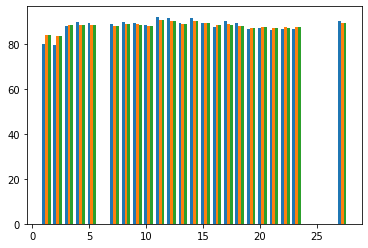

Comparing score:
    Origin  Normalization  Deselfish
1    79.71          83.69      83.69
2    79.59          83.56      83.28
3    87.76          88.46      88.46
4    89.71          88.36      88.36
5    89.41          88.51      88.51
7    88.65          88.04      88.04
8    89.47          88.69      88.69
9    89.06          88.85      88.50
10   88.47          88.01      88.01
11   92.00          90.70      90.70
12   91.53          90.04      90.04
13   89.29          88.69      88.69
14   91.59          90.25      90.25
15   89.24          89.27      89.27
16   87.59          88.34      88.34
17   89.88          88.62      88.29
18   89.12          87.77      87.77
19   86.76          86.86      86.86
20   86.88          87.52      87.52
21   86.29          87.19      86.95
22   86.76          87.47      87.20
23   86.76          87.22      87.22
27   89.94          89.35      89.35
/----------------------------------------------------/
Comparing rank:
    Origin  Normalizatio

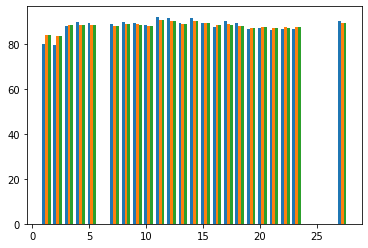

Comparing score:
    Origin  Normalization  Deselfish
1    79.71          83.69      83.69
2    79.59          83.56      83.28
3    87.76          88.46      88.46
4    89.71          88.36      88.36
5    89.41          88.51      88.51
7    88.65          88.04      88.04
8    89.47          88.69      88.69
9    89.06          88.85      88.50
10   88.47          88.01      88.01
11   92.00          90.70      90.70
12   91.53          90.04      90.04
13   89.29          88.69      88.69
14   91.59          90.25      90.25
15   89.24          89.27      89.27
16   87.59          88.34      88.34
17   89.88          88.62      88.29
18   89.12          87.77      87.77
19   86.76          86.86      86.86
20   86.88          87.52      87.52
21   86.29          87.19      86.95
22   86.76          87.47      87.20
23   86.76          87.22      87.22
27   89.94          89.35      89.35
/----------------------------------------------------/
Comparing rank:
    Origin  Normalizatio

In [15]:
if __name__ == "__main__":
    score_df = load_data()
    print("/----------------------------------------------------/")
    print("Solution 1: Drop all missing data:")
    score_origin, score_final_v1, score_norm_v2 = get_score(score_df, False)
    evaluate([score_origin, score_final_v1, score_norm_v2], ["Origin", "Normalization", "Deselfish"])
    print("/----------------------------------------------------/")
    print("Solution 2: Drop partial missing data:")
    score_origin, score_final_v1, score_norm_v2 = get_score(score_df, True)
    evaluate([score_origin, score_final_v1, score_norm_v2], ["Origin", "Normalization", "Deselfish"])

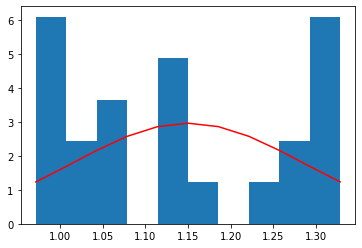

In [22]:
# num_bins = 10
# n, bins, patches = plt.hist(s_2, num_bins, density=1) 
# y_True = sta.norm.pdf(bins, s_2_mean, s_2_sigma)
# plt.plot(bins, y_True, color='r', label='True')

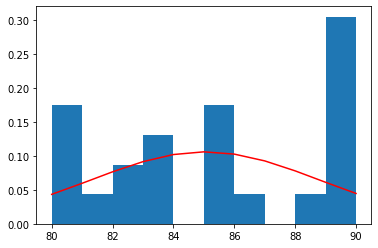

In [13]:
# num_bins = 10
# n, bins, patches = plt.hist(score_df_lite.loc[2], num_bins, density=1) 
# y_True = sta.norm.pdf(bins, score_df_lite.loc[2].mean(), score_df_lite.loc[2].std())
# plt.plot(bins, y_True, color='r', label='True')

In [14]:
# score_df_lite.loc[2]

1     85.0
2     85.0
3     90.0
4     82.0
5     90.0
7     85.0
8     89.0
9     83.0
10    85.0
11    89.0
12    88.0
13    83.0
14    90.0
15    90.0
16    90.0
17    83.0
18    81.0
19    82.0
20    80.0
21    80.0
22    80.0
23    80.0
27    86.0
Name: 2, dtype: float64